In [4]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, einsum

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerConfig
torch.manual_seed(8)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

2023-08-25 23:27:27.750946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
dataset = datasets.OxfordIIITPet(root='./data', target_types='segmentation', target_transform=transform, download=True, transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [3500, len(dataset)-3500])
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

100.0%


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100.0%


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


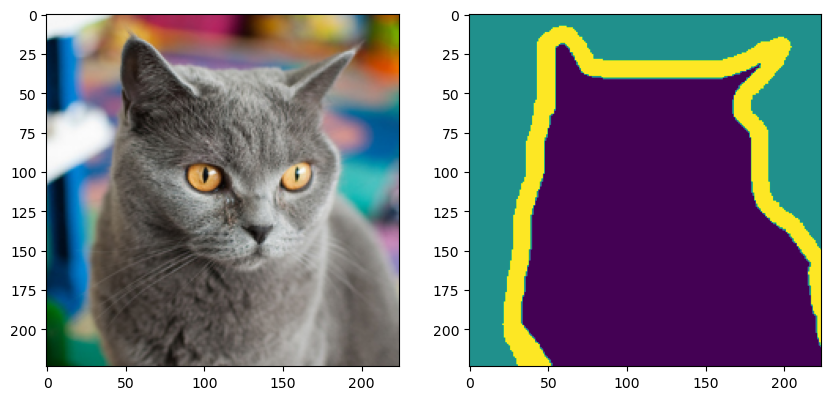

In [6]:
a, b = next(iter(train_loader))

# print(a.shape)
# print(b.shape)

# print(a[0])
# print(b[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

data_index = 9
ax[0].imshow(a[data_index].permute(1, 2, 0))
ax[1].imshow(b[data_index, 0])

### Train the SegFormer model

In [8]:
lr = 1e-3
num_epoch = 200
num_batch = np.ceil(len(train_set) / batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
id2label = {0: "outer", 1: "inner", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)
# model.load_state_dict(torch.load('./model_state_dicts/segformer.pth', map_location=torch.device('cpu')))

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

cpu


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for epoch in range(1, num_epoch+1):
    model.train()
    loss_list = []
    iou_list = []
    torch.save(model.state_dict(), '/model_state_dicts/segformer.pth')

    for batch, data in enumerate(train_loader, start=1):
        x, y = data
        x = x.to(device)
        unique_values, y_class = torch.unique(y, return_inverse=True)
        y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32).to(device)
        output, _ = model(x)
        # output = model(x).logits
        upsampled_logits = nn.functional.interpolate(output, scale_factor=4, mode="bilinear", align_corners=False)
        pred = upsampled_logits.argmax(dim=1)

        for batch_index in range(len(x)):
            class_iou = []
            for class_index in range(3):
                pred_tf = (pred[batch_index] == class_index).cpu().detach().numpy()
                target_tf = (y_class[batch_index][0] == class_index).cpu().detach().numpy()
                intersection = np.logical_and(target_tf, pred_tf)
                union = np.logical_or(target_tf, pred_tf)
                if np.sum(union) == 0:
                    iou_score = 0
                else:
                    iou_score = np.sum(intersection) / np.sum(union)
                class_iou.append(iou_score)
            iou_list.append(np.mean(class_iou) * 100)

        loss = loss_function(upsampled_logits, y_onehot)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list += [loss.item()]
        if batch % 10 == 0:
            print("TRAIN: EPOCH %03d / %03d | BATCH %03d / %03d | LOSS %.4f | MEAN IOU %.1f %%" % (epoch, num_epoch, batch, num_batch, np.mean(loss_list), np.mean(iou_list)))

### Test the trained model

In [ ]:
model.eval()

with torch.no_grad():

    loss_list = []
    iou_list = []

    for batch, data in enumerate(test_loader, start=1):
        x, y = data
        x = x.to(device)
        unique_values, y_class = torch.unique(y, return_inverse=True)
        y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32).to(device)
        output = model(x).logits
        upsampled_logits = nn.functional.interpolate(output, scale_factor=4, mode="bilinear", align_corners=False)
        pred = upsampled_logits.argmax(dim=1)

        for batch_index in range(len(x)):
            class_iou = []
            for class_index in range(3):
                pred_tf = (pred[batch_index] == class_index).cpu().detach().numpy()
                target_tf = (y_class[batch_index][0] == class_index).cpu().detach().numpy()
                intersection = np.logical_and(target_tf, pred_tf)
                union = np.logical_or(target_tf, pred_tf)
                if np.sum(union) == 0:
                    iou_score = 0
                else:
                    iou_score = np.sum(intersection) / np.sum(union)
                class_iou.append(iou_score)
            iou_list.append(np.mean(class_iou) * 100)

    print(f"MEAN IOU : {round(np.mean(iou_list), 1)}")

### Visualize model outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


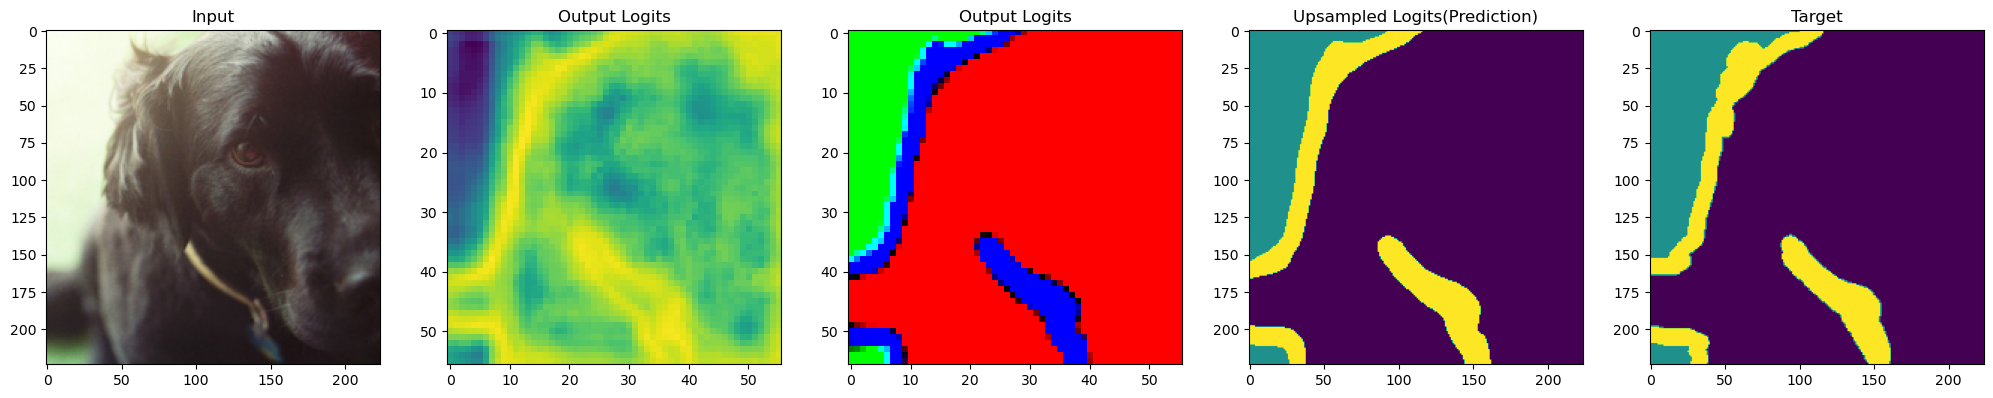

In [11]:
model.eval()

with torch.no_grad():
    
    a, b = next(iter(test_loader))
    a = a.to(device)
    
    unique, classes = torch.unique(b, return_inverse=True)
    onehot = nn.functional.one_hot(classes, 3).squeeze(dim=1).permute(0, 3, 1, 2)
    onehot = torch.argmax(onehot, dim=1)
    logits = model(a[0].unsqueeze(0)).logits
    upsampled_logits = nn.functional.interpolate(logits, scale_factor=4, mode="bilinear", align_corners=False)
    c = torch.argmax(upsampled_logits, dim=1)

    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    ax[0].imshow(a[0].permute(1, 2, 0).detach().cpu().numpy())
    ax[0].set_title('Input')
    ax[1].imshow(torch.sum(logits[0], 0).detach().cpu().numpy())
    ax[1].set_title('Output Logits')
    ax[2].imshow(logits[0].permute(1, 2, 0).detach().cpu().numpy())
    ax[2].set_title('Output Logits')
    ax[3].imshow(c[0].detach().cpu().numpy())
    ax[3].set_title('Upsampled Logits(Prediction)')
    ax[4].imshow(onehot[0].numpy())
    ax[4].set_title('Target')